# Lesson 6. Recurrent Neural Network

In this lesson we will explain what a RNN, compare it with a ANN and do an exercise. 

## 6.1. Concepts

### 6.1.1. RNN vs ANN

The main difference between a RNN and an ANN is that the RNN works with time steps. For example, our data is weather features like humidity, wind velocity, air density measured for each hour. Our model has to be able to predict the weather for the next hour given the weather of the previous 6 hours.

The data in a ANN goes linearly through the neural network to the output. But the RNN goes recurrently to the RNN layer so that it takes in count the different values in time.

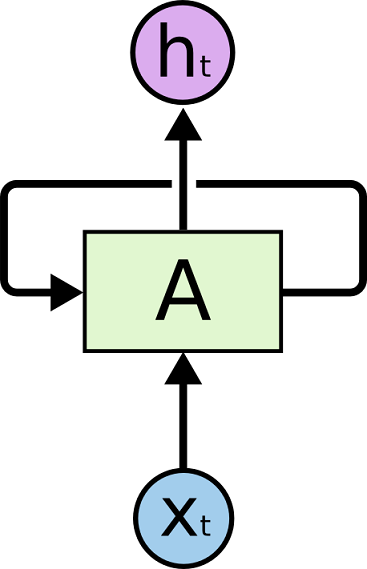

Image source: https://vidishajitani.medium.com/recurrent-neural-network-maths-69214e4d69e1

## 6.2. Examples

The code in this example is from [this tutorial](https://www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html) where the data is a sinusoidal function generated.

### Example 1. Generate the dataset

This RNN will predict the flow of a sine function. That can by generated with the *numpy* library.

The *arange* generates an array from 0 to ```size``` (1000) this array is passed to the numpy *sin* function that returns an array of those values making a sinusoidal function. An array of random values between 0 and 1 multiplied by 2 is added to the sinusoidal array.

This data is fetched into a pandas DataFrame object type.

In [ ]:
import pandas as pd
import numpy as np  

size = 1000

# array of numbers
t=np.arange(0,size)
# we make the sinusoidal function from that array
x=np.sin(0.02*t)+1.5*np.random.rand(size)
# fetched into a pandas dataframe
df = pd.DataFrame(x)
df.head()

0
0  0.983804
1  1.253984
2  0.230004
3  0.098191
4  0.806847

In [ ]:
#print('Normal array: ', np.arange(0,5))
arr = np.array([0,1,2,3,4])
print('Sin array: ', np.sin(0.02*arr))
print('Random array of values between 0 and 1 : ', np.random.rand(5))

Sin array:  [0.         0.01999867 0.03998933 0.05996401 0.07991469]
Random array of values between 0 and 1 :  [0.81205211 0.51169544 0.23123217 0.98646898 0.79889926]


This is how the sinusoidal function in form of array looks like:

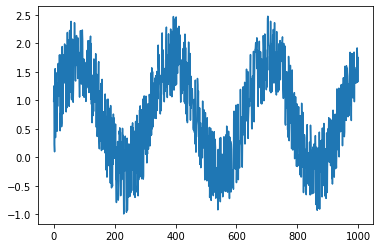

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df)
plt.show()

We add the ```1.5*np.random.rand(size)``` because we want to make it harder to the neural network to to learn. If we didn't multiplied by 1.5 the curve would be too clean.

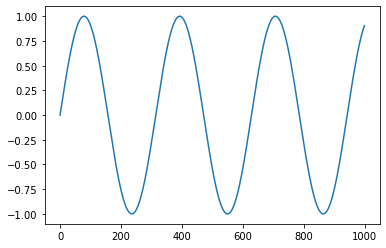

In [ ]:
t2=np.arange(0,size)
x2=np.sin(0.02*t2) # +1.5*np.random.rand(size)
df2 = pd.DataFrame(x2)
plt.plot(df2)
plt.show()

### Example 2. Separate train and test

Now we separate the dataset into training data and testing data.

In [ ]:
train_size = 800

values=df.values
train = values[0:train_size,:]
test = values[train_size:size,:]

### Example 3. Reshape dataset for RNN

Our RNN needs an step to make the prediction. The step is the number of elements that it takes to predict the next one. For example:

We have an array ```a=[1,2,3,4,5,6]``` if our step is 1, the data would be:
* X: 1 - y: 2
* X: 2 - y: 3
* ...
* X: 4 - y: 5
* X: 5 - y: 6

If the step was 3, the data would be:
* X: 1,2,3 - y: 4
* X: 2,3,4 - y: 5
* X: 3,4,5 - y: 6

Our step is going to be 5. Because we want it to make 1000 predictions (ys) we need to increment in 5 the array so that it has that extra step to actually making 1000 and not 995. If not it would finish in 995,996,997,998,999 and not in 1000,1001,1002,1003,1004.

In [ ]:
print(len(test))
print(test[195:200])

200
[[1.31666312]
 [1.92093561]
 [1.7760486 ]
 [1.3240733 ]
 [1.75183036]]


In [ ]:
step = 5
# reversed five items of train and test
train_rev = list(train[795:800])[::-1]
train_rev = np.array(train_rev)
test_rev = list(test[195:200])[::-1]
test_rev = np.array(test_rev)

# add step elements into train and test
train = np.append(train,train_rev)
test = np.append(test,test_rev)

As you can see, the size increased in 5 and the last five values are the same as the five previous but reversed.

In [ ]:
print(len(test))
print(test[200:205])

205
[1.75183036 1.3240733  1.7760486  1.92093561 1.31666312]


Now we have to obtain the Xs and ys from that data. The ys are going to be five values ahead of the first item of the five Xs (because our step is 5). 

What this function does is that it takes the data and step and iterates through the dataset appending into a X list all the values but from blocks of five and to the y values 5 values ahead.

In [ ]:
# convert into dataset matrix
def to_matrix(data, step):
    X = []
    y = []
    for i in range(len(data)-step):
        # calculates the position i+5
        d=i+step  
        # appends to the X the interval of the i position to the d-1 one
        X.append(data[i:d,])
        # appends to the y the position d (the prediction of the previous 5)
        y.append(data[d,])
    return np.array(X), np.array(y)

In [ ]:
X_train,y_train = to_matrix(train,step)
X_test,y_test =to_matrix(test,step)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Example 4. Build and compile the model

Our model will be constituted by a SimpleRNN layer:
* the units are the dimensinality of the output space
* the input shape has to be (1,5) because the step is 5
* There is a Dense layer of size 8, the number is arbitrary but 8 works fine for this RNN 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))

Now the loss is not anymore the 'categorical_crossentropy' because the problem is not a classification one. We can see a summary of the model layers with the *summary* method.

In [ ]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1216      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


### Example 5. Fit the model

To train the model we use the *fit* function as usual.

In [ ]:
model.fit(X_train,y_train, epochs=100, batch_size=16, verbose=2)

Epoch 1/100
50/50 - 1s - loss: 0.9671
Epoch 2/100
50/50 - 0s - loss: 0.2554
Epoch 3/100
50/50 - 0s - loss: 0.2281
Epoch 4/100
50/50 - 0s - loss: 0.2212
Epoch 5/100
50/50 - 0s - loss: 0.2163
Epoch 6/100
50/50 - 0s - loss: 0.2151
Epoch 7/100
50/50 - 0s - loss: 0.2132
Epoch 8/100
50/50 - 0s - loss: 0.2124
Epoch 9/100
50/50 - 0s - loss: 0.2110
Epoch 10/100
50/50 - 0s - loss: 0.2104
Epoch 11/100
50/50 - 0s - loss: 0.2093
Epoch 12/100
50/50 - 0s - loss: 0.2092
Epoch 13/100
50/50 - 0s - loss: 0.2094
Epoch 14/100
50/50 - 0s - loss: 0.2084
Epoch 15/100
50/50 - 0s - loss: 0.2072
Epoch 16/100
50/50 - 0s - loss: 0.2074
Epoch 17/100
50/50 - 0s - loss: 0.2078
Epoch 18/100
50/50 - 0s - loss: 0.2056
Epoch 19/100
50/50 - 0s - loss: 0.2044
Epoch 20/100
50/50 - 0s - loss: 0.2065
Epoch 21/100
50/50 - 0s - loss: 0.2047
Epoch 22/100
50/50 - 0s - loss: 0.2049
Epoch 23/100
50/50 - 0s - loss: 0.2053
Epoch 24/100
50/50 - 0s - loss: 0.2031
Epoch 25/100
50/50 - 0s - loss: 0.2042
Epoch 26/100
50/50 - 0s - loss: 0.

### Example 6. Evaluate the model

To evaluate the model we use the *evaluate* function and we pass the test dataset. And we obtain the loss value.

In [ ]:
model.evaluate(X_test, y_test, verbose=0)

0.1911497861146927

A more visual way to see if our model does well is to plot the data and the prediction of that data. The first 800 values will be the train data and the last 200 will be the test data, these will be separated by a red vertical line in the positon 800.

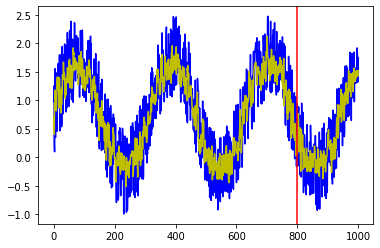

In [ ]:
# prediction of the train data
trainPredict = model.predict(X_train)
# prediction of the test data
testPredict= model.predict(X_test)
# we concatenate both
predicted=np.concatenate((trainPredict,testPredict),axis=0)


# this plots the train data in blue color
plt.plot(df[0], c='b')
# this plots the prediction of train and test in yellow color
plt.plot(predicted, c='y')
# Red line to separate between train and test data
plt.axvline(df.index[train_size], c="r")
plt.show()

## 6.3. Final exercise

### Exercise 1. Generate the dataset

Generate an array of a cosine function like of size 1000. The values inside the *cos* function are multiplied by 0.03 and an array of size 1000 of random integers between 0 and 1 multiplied by 2 is added to the cosine array.

In [ ]:
# make the cosine function inside the pandas dataframe


In [ ]:
import pandas as pd
import numpy as np  

size = 1000

t=np.arange(0,size)
x=np.cos(0.03*t)+1.5*np.random.rand(size)
df = pd.DataFrame(x)
df.head()

0
0  1.218455
1  1.571537
2  1.079881
3  2.388997
4  1.323040

Plot the result

In [ ]:
# plot the result


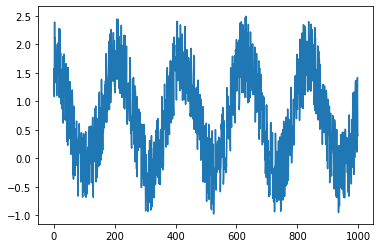

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df)
plt.show()

The result should look like:

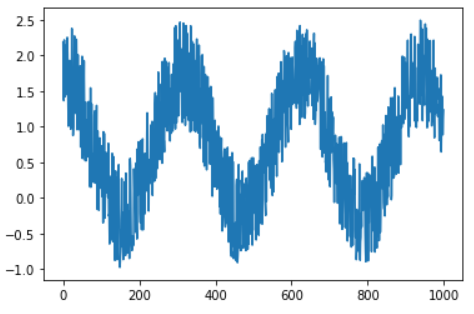

### Example 2. Separate train and test

Separate the dataset into training data and testing data. The train data size must be 800 and the test 200.

In [ ]:
# separate the data into train and test


In [ ]:
train_size = 800

values=df.values
train = values[0:train_size,:]
test = values[train_size:size,:]

### Example 3. Reshape dataset for RNN

With step = 4. Prepare the dataset for the RNN 

Add the items necesary to the RNN so that X and y arrays for train and test are size 1000.

In [ ]:
# with step four, add the reversed last four items to the train and test arrays


In [ ]:
step = 4
# reversed five items of train and test
train_rev = list(train[795:800])[::-1]
train_rev = np.array(train_rev)
test_rev = list(test[195:200])[::-1]
test_rev = np.array(test_rev)

# add step elements into train and test
train = np.append(train,train_rev)
test = np.append(test,test_rev)

Use the function *to_matrix* that is already created to create the X_train, y_train, X_test and y_test with the correct shape.

In [ ]:
# use the function to matrix here


#reuse this code to reshape the given arrays
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train,y_train = to_matrix(train,step)
X_test,y_test =to_matrix(test,step)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Example 4. Build and compile the model

Build a Sequential model with three layers:
* **SimpleRNN**: units=32, input_shape=(determine it), activation: "relu"
* **Dense**: units=(determine it), activation=(determine it)
* **Dense**: units=(determine it)

In [ ]:
# Build the model


In [ ]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))

Compile the model with loss=mean_squared_error and optimizer=rmsprop

In [ ]:
# Compile the model

In [ ]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


### Example 5. Fit the model

Fit the model with 100 epochs and batch size= 16

In [ ]:
# fit the model with the training data


In [ ]:
model.fit(X_train,y_train, epochs=100, batch_size=16, verbose=2)

Epoch 1/100
51/51 - 1s - loss: 0.5755
Epoch 2/100
51/51 - 0s - loss: 0.2508
Epoch 3/100
51/51 - 0s - loss: 0.2411
Epoch 4/100
51/51 - 0s - loss: 0.2381
Epoch 5/100
51/51 - 0s - loss: 0.2358
Epoch 6/100
51/51 - 0s - loss: 0.2332
Epoch 7/100
51/51 - 0s - loss: 0.2322
Epoch 8/100
51/51 - 0s - loss: 0.2311
Epoch 9/100
51/51 - 0s - loss: 0.2298
Epoch 10/100
51/51 - 0s - loss: 0.2297
Epoch 11/100
51/51 - 0s - loss: 0.2290
Epoch 12/100
51/51 - 0s - loss: 0.2286
Epoch 13/100
51/51 - 0s - loss: 0.2280
Epoch 14/100
51/51 - 0s - loss: 0.2277
Epoch 15/100
51/51 - 0s - loss: 0.2280
Epoch 16/100
51/51 - 0s - loss: 0.2273
Epoch 17/100
51/51 - 0s - loss: 0.2265
Epoch 18/100
51/51 - 0s - loss: 0.2256
Epoch 19/100
51/51 - 0s - loss: 0.2258
Epoch 20/100
51/51 - 0s - loss: 0.2270
Epoch 21/100
51/51 - 0s - loss: 0.2257
Epoch 22/100
51/51 - 0s - loss: 0.2256
Epoch 23/100
51/51 - 0s - loss: 0.2251
Epoch 24/100
51/51 - 0s - loss: 0.2254
Epoch 25/100
51/51 - 0s - loss: 0.2252
Epoch 26/100
51/51 - 0s - loss: 0.

### Example 6. Evaluate the model

Evaluate the model with the test data

In [ ]:
# Evaluate the model


In [ ]:
model.evaluate(X_test, y_test, verbose=0)

0.25540003180503845

Plot the predictions of the train data with the test data concatenated and also the data with a line in the position 800.

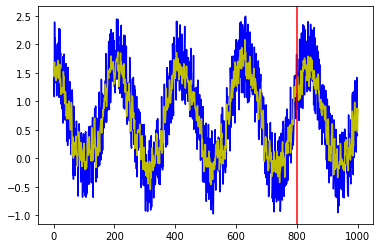

In [ ]:
# prediction of the train data
trainPredict = model.predict(X_train)
# prediction of the test data
testPredict= model.predict(X_test)
# we concatenate both
predicted=np.concatenate((trainPredict,testPredict),axis=0)


# this plots the train data in blue color
plt.plot(df[0], c='b')
# this plots the prediction of train and test in yellow color
plt.plot(predicted, c='y')
# Red line to separate between train and test data
plt.axvline(df.index[train_size], c="r")
plt.show()